In [93]:
# SalesInsightsPreprocessing
from SamplingScript import *

# libraries to visualize
import matplotlib.pyplot as plt

# Import regression models
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.metrics import accuracy_score, mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score

## some stuff for making pretty plots
from matplotlib import rcParams
from cycler import cycler

### Tensorflow and Keras imports ###
# Import TensorFlow for machine learning
import tensorflow as tf
# Import Keras for high-level neural networks API
from tensorflow import keras
# Import Dense and Activation layers for neural network architecture
from tensorflow.keras.layers import Dense, Activation
# Import Sequential for linear stacking of layers
from keras.models import Sequential
# Import KerasClassifier to make Keras models compatible with scikit-learn
from scikeras.wrappers import KerasClassifier, KerasRegressor

## Set plotting style and print options
sns.set_theme()
sns.set_style("whitegrid")
sns.set_context("paper") #Possible are paper, notebook, talk and poster
# Set figure format
wide_format, square_format = False, True
if wide_format:
    d = {'lines.linewidth': 2, 'axes.titlesize': 18, 'axes.labelsize': 18, 'xtick.labelsize': 12, 'ytick.labelsize': 12,\
     'legend.fontsize': 15, 'font.family': 'serif', 'figure.figsize': (9,6)}
if square_format:
    d = {'lines.linewidth': 2, 'axes.titlesize': 16, 'axes.labelsize': 14, 'xtick.labelsize': 10, 'ytick.labelsize': 10,\
     'legend.fontsize': 12, 'font.family': 'serif', 'figure.figsize': (6,6)}
    
d_colors = {'axes.prop_cycle': cycler(color = ['teal', 'navy', 'coral', 'plum', 'purple', 'olivedrab',\
         'black', 'red', 'cyan', 'yellow', 'khaki','lightblue'])}
rcParams.update(d)
rcParams.update(d_colors)

#### Extra functions

In [94]:
training_data = [(X_train, y_train), (X_res_20k, y_res_20k), (X__res_50k, y_res_50k), (X_res_100k, y_res_100k), (X_res_500k, y_res_500k)]
titles = ['OG df', '20k df', '50k df', '100k df', '500k df']
dataframes = [df, df_resampled_20000, df_resampled_50000, df_resampled_100000, df_resampled_500000]

In [95]:
def calculate_relative_errors(y_prediction):
    non_zero_mask = (y_test != 0)
    rel_error = np.mean(np.abs(y_test[non_zero_mask] - y_prediction[non_zero_mask]) / y_test[non_zero_mask])
    rel_error_med = np.median(np.abs(y_test[non_zero_mask] - y_prediction[non_zero_mask]) / y_test[non_zero_mask])
    rel_quan = np.quantile(np.abs(y_test[non_zero_mask] - y_prediction[non_zero_mask]) / y_test[non_zero_mask], [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
    
    return rel_error, rel_error_med, rel_quan

In [96]:
def plot_true_vs_predicted(y_test, yPredLst, rSqrdLst):
    fig, ax = plt.subplots(ncols=len(titles), figsize=(15,5))
    ax = ax.flatten() 
    fig.suptitle('True vs predicted')

    for i in range(5):
        ax[i].plot(y_test, yPredLst[i], '.', markersize=1.5, alpha=.6)
        ax[i].set(xlabel='True value', ylabel='Predicted value', title=titles[i], ylim=[0,5000], xlim=[0,5000])
        ax[i].text(1000, 4000, rf'$R^2$ = {rSqrdLst[i]:.3f}', fontsize=12)

    fig.tight_layout()
    plt.show()

In [97]:
def plot_feature_importance(featImportLst):
    fig, ax = plt.subplots(ncols=len(titles), figsize=(15, 5))
    ax = ax.flatten()
    fig.suptitle('Feature Importance for Different Dataframes')

    for i in range(5):
        features = dataframes[i].drop(['Volume', 'Account Description', 'Size', 'Year Month (after 2000) in Datetime', 'Value'], axis=1).columns
        importances = featImportLst[i]
        indices = np.argsort(importances)
        
        ax[i].barh(features[indices], importances[indices])
        ax[i].set(xlabel='Importance', ylabel='Feature', title=titles[i])

    fig.tight_layout()
    plt.show()

In [98]:
def plot_evaluation_results(history):

    # make a list of the train and val metrics
    metrics = list(history.history.keys())
    
    # make lists of train and val metrics
    val_metrics = [entry for entry in metrics if entry.startswith('val_')]
    train_metrics = [entry for entry in metrics if not entry.startswith('val_')]

    # the number of metrics to plot
    Nmetrics = len(val_metrics)
    width = 6 * Nmetrics

    fig, ax = plt.subplots(ncols = Nmetrics, figsize=(width, 6))

    # plot the train and val results for each metric
    for i, axx in enumerate(ax):
        ax[i].plot(history.history[train_metrics[i]], label='train', alpha = 0.7)  
        ax[i].plot(history.history[val_metrics[i]], label='test', alpha = 0.7)
        ax[i].set_ylabel(f'{train_metrics[i].capitalize()}')
        ax[i].set_xlabel('Epoch')
        ax[i].legend(loc='best')
    fig.tight_layout()
    return fig, ax 

In [99]:
def evaluate_regression_results(model, X_train, y_train,\
                                           metrics = [r2_score, mean_absolute_error], metric_names = ['r2', 'MAE']):
    
    # make predictions
    y_pred_train = model.predict(X_train, verbose = 0)   
    y_pred_val = model.predict(X_test, verbose = 0)

    # calculate metrics
    for metric, metric_name in zip(metrics, metric_names):
        metric(y_train, y_pred_train.round())
        print(f'{metric_name} on training data: {metric(y_train, y_pred_train.round()):.3f}')
        print(f'{metric_name} on validation data: {metric(y_test, y_pred_val.round()):.3f}')
        return

#### Linear Regression

In [61]:
lin_reg = LinearRegression()

r_sqrd_list_linreg = []
y_pred_list_linreg = []

for X, y in training_data:
    # fit and predict
    lin_reg.fit(X, y)
    y_pred = lin_reg.predict(X_test)
    
    # calculate the R^2 score
    rsquared = lin_reg.score(X_test, y_test)
    rel_error, rel_error_med, rel_quan = calculate_relative_errors(y_pred)

    y_pred_list_linreg.append(y_pred)
    r_sqrd_list_linreg.append(rsquared)
    print(f'Relative error: {rel_error * 100 :.3f} %')
    print(f'Relative median error: {rel_error_med * 100 :.3f} %')
    print(rel_quan * 100, '%')
    print(f'R squared: {rsquared:.3f}')
    print('')

Relative error: 3164.181 %
Relative median error: 749.651 %
[  29.48425185   64.70478696  183.95469426  403.59637104  749.65070382
 1462.30968214 2978.46517607 4922.37843484 9167.74487382] %
R squared: 0.351

Relative error: 3144.837 %
Relative median error: 726.471 %
[  29.80855349   62.16260616  171.1102474   398.44041022  726.47070362
 1426.5402929  3034.20241564 5083.85950118 9259.08982643] %
R squared: 0.354

Relative error: 3130.806 %
Relative median error: 720.494 %
[  29.73698769   62.30350886  178.54024226  405.49869738  720.4938693
 1434.4169993  2952.55236253 4868.03246841 9068.92292137] %
R squared: 0.352

Relative error: 3166.849 %
Relative median error: 752.288 %
[  29.85424094   63.32932654  185.97356676  407.20005297  752.2876807
 1487.93903244 2978.27553462 4874.59705665 9158.32795964] %
R squared: 0.351

Relative error: 3182.371 %
Relative median error: 764.681 %
[  29.18283771   63.63537592  185.31612932  411.68498091  764.68142441
 1482.64309544 2982.16834144 4933.1

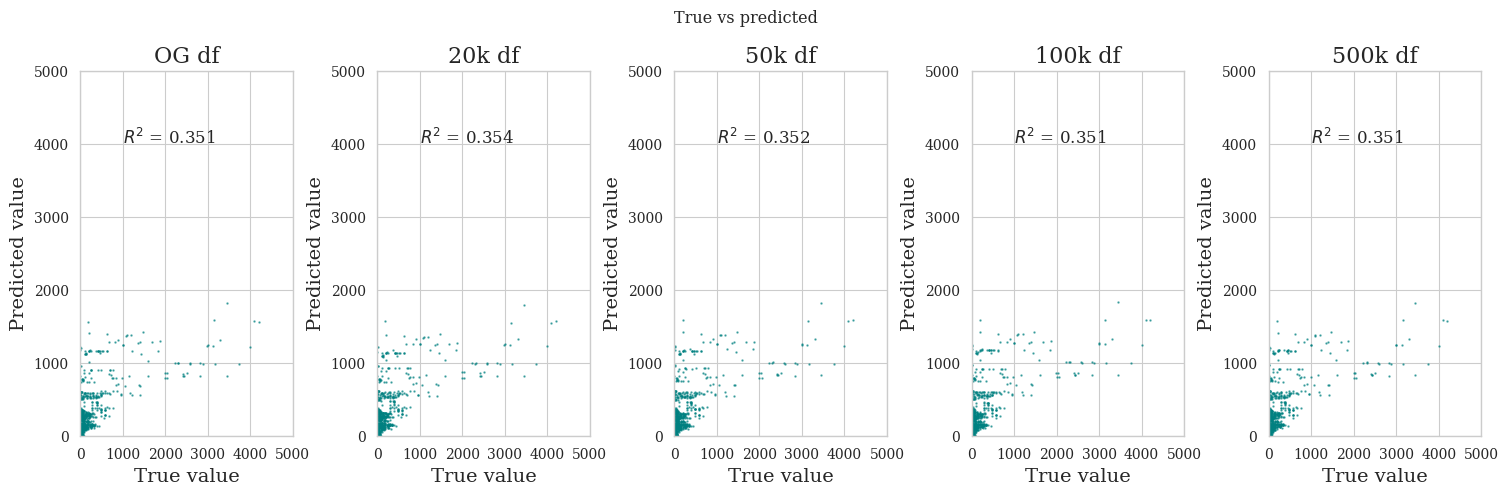

In [27]:
plot_true_vs_predicted(y_test, y_pred_list_linreg, r_sqrd_list_linreg)

#### Random Forest with hyperparameter tuning

In [32]:
ran_for_reg = RandomForestRegressor(max_depth=df.columns.size, random_state=42)

y_pred_list_ranfor = []
r_sqrd_list_ranfor = []
feat_import_list_ranfor = []

for X, y in training_data:
    # fit and predict
    ran_for_reg.fit(X, y)
    y_pred = ran_for_reg.predict(X_test)

    # calculate the R^2 score
    rsquared = ran_for_reg.score(X_test, y_test)

    non_zero_mask = (y_test != 0)
    rel_error, rel_error_med, rel_quan = calculate_relative_errors(y_pred)
    
    y_pred_list_ranfor.append(y_pred)
    r_sqrd_list_ranfor.append(rsquared)
    feat_import_list_ranfor.append(ran_for_reg.feature_importances_)
    print(f'Relative error: {rel_error * 100 :.3f} %')
    print(f'Relative median error: {rel_error_med * 100 :.3f} %')
    print(f'Relative quantile error: {rel_quan * 100} %')
    print(f'R squared: {rsquared:.3f}')
    print()

Relative error: 171.725 %
Relative median error: 24.648 %
Relative quantile error: [2.00000000e+00 5.74375000e+00 1.07939840e+01 1.73917056e+01
 2.46476190e+01 3.47336811e+01 4.50000000e+01 5.74544402e+01
 9.47500000e+01 1.30490000e+05] %
R squared: 0.779

Relative error: 110.796 %
Relative median error: 28.251 %
Relative quantile error: [0.00000000e+00 2.78468753e+00 1.07304762e+01 1.91115942e+01
 2.82507084e+01 3.89133903e+01 5.00000000e+01 6.58613462e+01
 9.89000000e+01 3.56840000e+04] %
R squared: 0.758

Relative error: 100.315 %
Relative median error: 29.500 %
Relative quantile error: [0.00000000e+00 2.00000000e+00 1.00000000e+01 1.93750779e+01
 2.95000000e+01 3.99812500e+01 5.00000000e+01 6.66666667e+01
 9.88000000e+01 3.56120000e+04] %
R squared: 0.753

Relative error: 89.980 %
Relative median error: 29.825 %
Relative quantile error: [0.00000000e+00 1.19566864e+00 1.00000000e+01 1.92432602e+01
 2.98245614e+01 4.00285210e+01 5.00000000e+01 6.69544963e+01
 1.00000000e+02 3.5804000

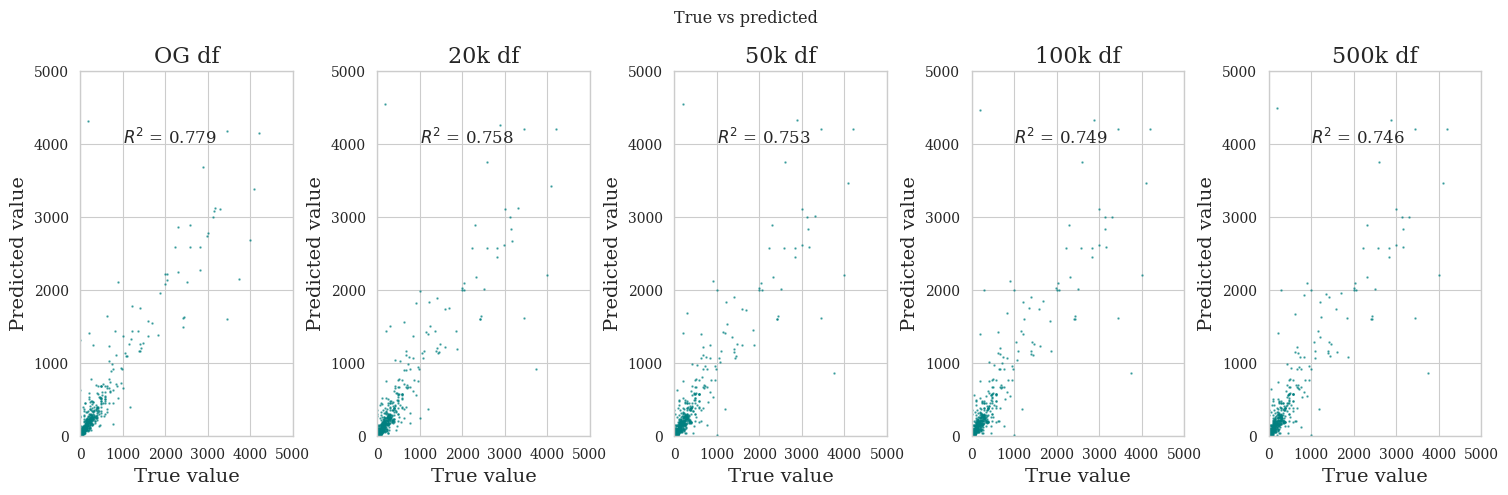

In [33]:
plot_true_vs_predicted(y_test, y_pred_list_ranfor, r_sqrd_list_ranfor)

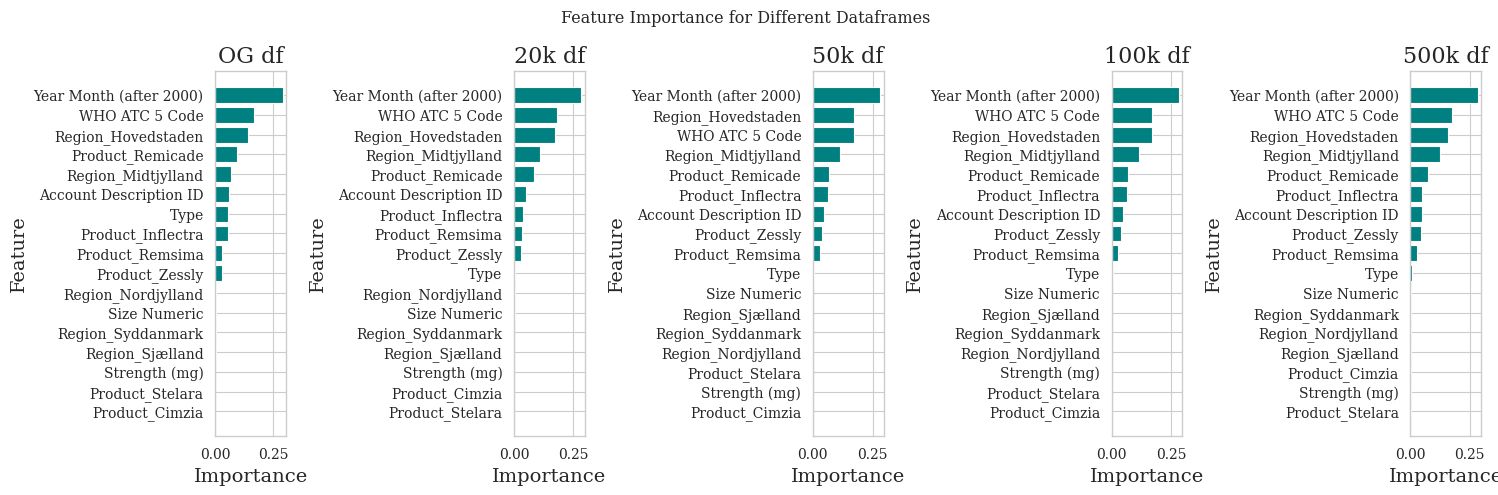

In [34]:
plot_feature_importance(feat_import_list_ranfor)

#### XGBoost

In [35]:
xgb = XGBRegressor()

In [62]:
y_pred_list_xgb = []
r_sqrd_list_xgb = []
feat_import_list_xgb = []

for x,y in training_data:
    xgb.fit(x, y)
    y_pred_xgb = xgb.predict(X_test)
    rsquared_xgb = xgb.score(X_test, y_test)
    non_zero_mask = (y_test != 0)
    rel_error, rel_error_med, rel_quan = calculate_relative_errors(y_pred_xgb)

    y_pred_list_xgb.append(y_pred_xgb)
    r_sqrd_list_xgb.append(rsquared_xgb)
    feat_import_list_xgb.append(xgb.feature_importances_)
    print(f'Relative error: {rel_error * 100 :.3f} %')
    print(f'Relative median error: {rel_error_med * 100 :.3f} %')
    print(rel_quan * 100, '%')
    print(f'R squared: {rsquared_xgb:.3f}')
    print('')

Relative error: 415.071 %
Relative median error: 59.195 %
[  6.67415336  15.85844338  27.30406165  39.71572995  59.19488668
  91.93901658 142.78758049 243.91182423 465.18779755] %
R squared: 0.753

Relative error: 395.643 %
Relative median error: 54.025 %
[  7.92555258  15.66536039  25.84683418  37.4560672   54.02541757
  82.15214849 140.54738283 251.15791321 456.81251526] %
R squared: 0.731

Relative error: 362.877 %
Relative median error: 56.074 %
[  7.96179295  15.32382607  25.58177888  37.59316742  56.07410073
  84.56583738 140.39693117 222.77357578 406.72657967] %
R squared: 0.727

Relative error: 354.654 %
Relative median error: 54.827 %
[  7.25389048  14.57563788  23.94857675  36.2647897   54.82710004
  80.31692147 127.43256569 212.50264645 390.55549145] %
R squared: 0.749

Relative error: 379.763 %
Relative median error: 52.414 %
[  6.58125281  13.73652726  23.86487871  35.91588199  52.41388679
  80.49350262 128.26632977 215.86410999 396.20865822] %
R squared: 0.751



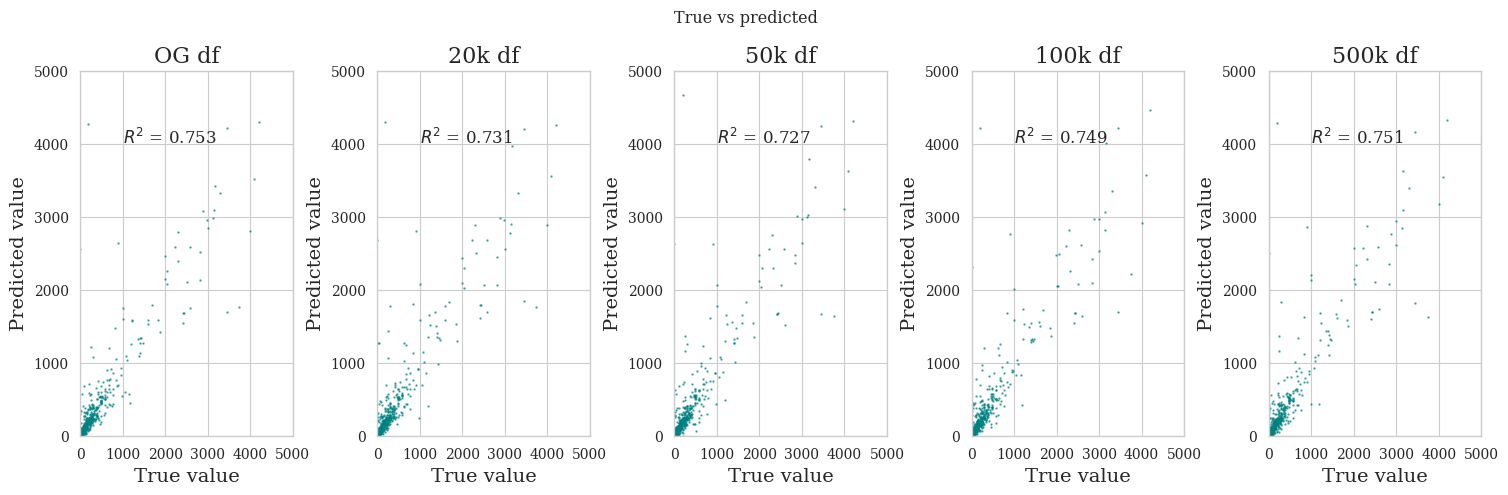

In [38]:
plot_true_vs_predicted(y_test, y_pred_list_xgb, r_sqrd_list_xgb)

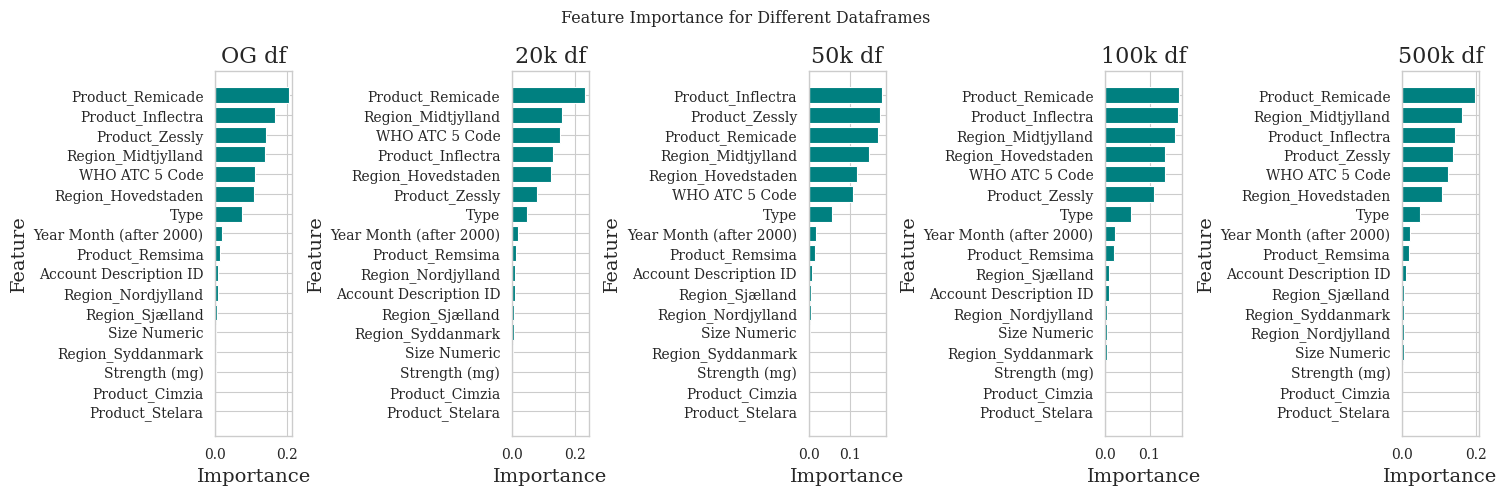

In [39]:
plot_feature_importance(feat_import_list_xgb)

#### Artificial Neural Network regression

In [101]:
### Create an instance of a Keras Sequential model.
# Sequential models are appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor.
model = keras.models.Sequential()

### Add layers to the model.
# Add an Input layer to the model.
# The 'shape' argument specifies the shape of the input data, which here matches the number of features in X_train.
model.add(keras.layers.Input(shape=(X_train.shape[1],)))

# Add the first hidden layer with e.g. 15 units and ReLU (Rectified Linear Unit) activation function.
# ReLU activation function replaces all negative values in the output with zero.
model.add(keras.layers.Dense(15, activation='relu'))

# Add the second hidden layer with e.g. 20 units and ReLU activation function.
model.add(keras.layers.Dense(20, activation='relu'))
model.add(keras.layers.Dense(20, activation='relu'))

# Add the output layer with a single unit and a sigmoid activation function.
# The linear function is often used in the output layer for regression problems.
# It squashes the output to lie in the range of 0 to 1, which can be interpreted as probabilities.
model.add(keras.layers.Dense(1, activation='linear'))
model.summary()


Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_60 (Dense)                │ (None, 15)             │           270 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ (None, 20)             │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_62 (Dense)                │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_63 (Dense)                │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,031 (4.03 KB)

 Trainable params: 1,031 (4.03 KB)

 Non-trainable params: 0 (0.00 B)

In [102]:
# Compile the model with the necessary attributes.
# - loss function: 'binary_crossentropy' is commonly used for binary classification problems.
# - optimizer: 'adam' is a popular optimization algorithm that is an extension of stochastic gradient descent.
# - learning rate: how quickly the model updates it weights. A large learning rate causes the model to adapt more quickly,
#                  but at the cost of stability
# - metrics: 'accuracy' is used to evaluate the model (but there are many good choices).

# Compile the model with the necessary attributes and the default learning rate.
model.compile(loss=tf.keras.losses.MeanAbsoluteError(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), \
              metrics=[tf.keras.metrics.LogCoshError()])

In [103]:
# Convert to numpy arrays
X_train = np.array(X_train, dtype=np.float32)
y_train = np.array(y_train, dtype=np.float32)
X_test = np.array(X_test, dtype=np.float32)
y_test = np.array(y_test, dtype=np.float32)

In [104]:
# batch_size: the number of samples that will be propagated through the network. a smaller batch size will take longer to train,
#             but will be more accurate. A larger batch size will train faster, but will be less accurate.
# epochs: the number of times the model will cycle through the data. A larger number of epochs will take longer to train,

history = model.fit(X_train, y_train, batch_size=128, epochs=125, validation_data=(X_test, y_test), verbose=0)

(<Figure size 1200x600 with 2 Axes>,
 array([<Axes: xlabel='Epoch', ylabel='Logcosh'>,
        <Axes: xlabel='Epoch', ylabel='Loss'>], dtype=object))

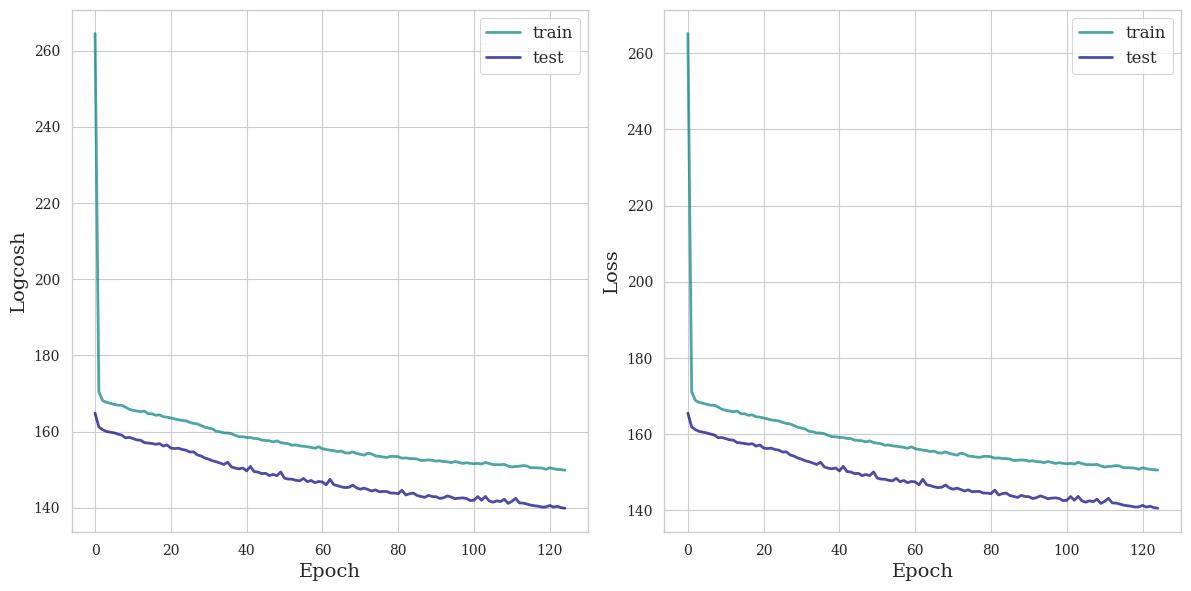

In [105]:
plot_evaluation_results(history)

In [106]:
# define a function to calculate the relative error
def relative_error(y_true, y_pred):
    zero_mask = y_true != 0
    return np.nanmean(np.abs((y_true[zero_mask] - y_pred[zero_mask]) / y_true[zero_mask]))

In [107]:
evaluate_regression_results(model, X_train, y_train, metrics = [relative_error, r2_score,], metric_names = ['Mean relative error', 'r2',])

Mean relative error on training data: 19.441
Mean relative error on validation data: 18.841


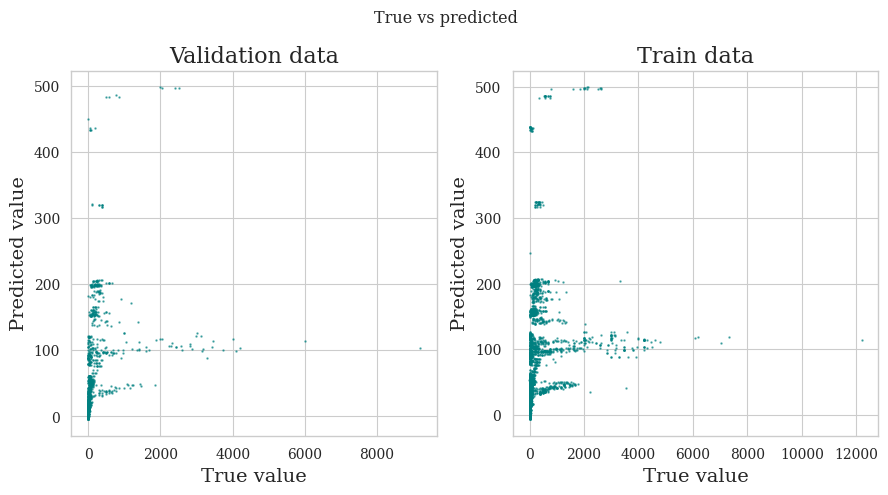

In [108]:
## Visualize the predictions
y_pred_train = model.predict(X_train, verbose = 0)
y_pred_val = model.predict(X_test, verbose = 0)

fig, ax = plt.subplots(ncols=2, figsize=(9,5))
ax = ax.flatten()
fig.suptitle(f'True vs predicted')
ax[0].plot(y_test, y_pred_val, '.', markersize = 1.5, alpha = .6)
ax[0].set(xlabel = 'True value', ylabel = 'Predicted value', title = 'Validation data')
ax[1].plot(y_train, y_pred_train, '.', markersize = 1.5, alpha = .6)
ax[1].set(xlabel = 'True value', ylabel = 'Predicted value', title = 'Train data')
fig.tight_layout()

#### TODO: 

xgboost //
ANN

Lav boxplot der viser resultatet for hver model
